# Challenge 0: Does this Run? :)

In [521]:
import jax
import numpy as np
from jax import numpy as jnp
from matplotlib import pyplot as plt
%matplotlib inline

# Challenge 1.

JAX is basically numpy on steroids. Here you are able to put it to the test! Show off your best numpy skills, try to find somewhere where JAX and numpy syntax is different.

In [515]:
M = jnp.array(np.random.randn(10, 10))

# Challenge 2: Gradients Can Be Annoying

Plot the derivative of $sin(x/2\pi)$


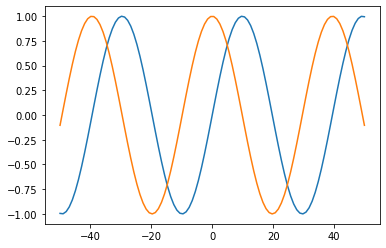

In [514]:
x = jnp.linspace(-50, 50, 100)

plt.plot(x, jnp.sin(x/(2*jnp.pi)))

plt.plot(x, jax.vmap(jax.grad(jnp.sin))((x/(2*jnp.pi))))

Plot the all **n** derivatives of an n-th order polynomial. Typ: use `functools.partial` to get rid of the roots argument and `jax.vmap`.

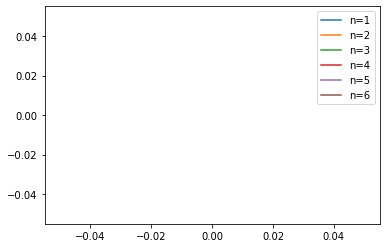

In [518]:
n = 6
roots = np.random.uniform(-3, 3, n).astype(np.float64)
def nth_order_polynomial(x, roots):
    y = 1
    for r in roots:
        y = y*(x-r)
    return y


# n-th order derivatives of this function?
for i in range(n):
    # TODO your code goes here
    x=[];y=[]; 
    plt.plot(x, y, label=f'n={i+1}')
plt.legend()


# Challenge 3: Random Numbers **Are** Annoying

JAX doesn't use statefule random number generators, but rather relies on a splittable key that needs to be passed around. This ensures that all operations are `deterministic` in a sense, a function parameter to output mappings are consistent.

How would you make a stateful random number generator for JAX?

# Challenge 4: Making Use of Hessians

Normally we use first-order information when doing gradient descent, so:
$$
\theta_{t+1} = \theta_t + \nabla_\theta f
$$


Using Taylor expansion, we can approximate the function $f(x)$. Similarly, we can approximate the gradient of the function via Taylor (you can look at h as being our update step)

$$
\nabla_x f(x+h) \approx \nabla_x f   + \nabla_x^2 f h
$$

Questions:
* How can we use this to improve convergence time for our quadratic function?
* In how many steps did it converge to the solution?

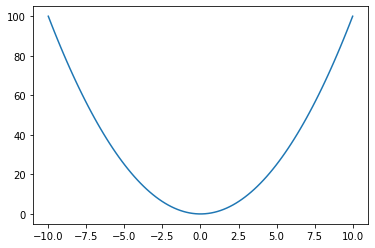

In [537]:
d = 10

@jax.jit
def square(x):
    return (x**2).sum(-1)


x = np.linspace(-10, 10, 100)[:, None]
# slice at dim=0
plt.plot(x, square(x))



Converged in 299 steps, 0.001, [0.02332505 0.02332505 0.02332505 0.02332505 0.02332505 0.02332505
 0.02332505 0.02332505 0.02332505 0.02332505]


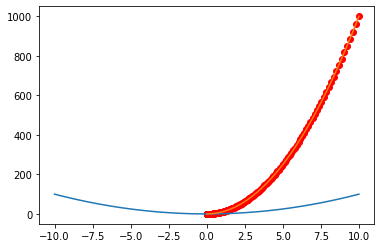

In [543]:
### don't touch ! ###
x0 = jnp.array([10.0]*d)
f = square
x_ = x0
trajx = [x0[0]]
trajy = [f(x0)]
err = 1e-3
#####################

for i in range(300):
    
    #### TODO update this part
    g = jax.grad(f)(x_)
    x_ -= 0.01*g
    #### TODO ####

    trajx.append(x_[0])
    trajy.append(f(x_))

    if trajy[-1] < err:
        break

print(f"Converged in {i} steps, {err}, {x_}")
plt.plot(x, f(x))
plt.plot(trajx, trajy)
plt.scatter(trajx, trajy, color='red')

In [558]:
import flax
from typing import Optional

@jax.vmap
def kl_divergence(mean, logvar):
  return -0.5 * jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar))

@jax.vmap
def binary_cross_entropy_with_logits(logits, labels):
  logits = flax.linen.log_sigmoid(logits)
  return -jnp.sum(labels * logits + (1. - labels) * jnp.log(-jnp.expm1(logits)))


@jax.jit
def loss(logits, mean, logvar):
  # TODO your code here, use the upper two losses
  pass

from typing import Sequence
class Sequential(flax.linen.Module):
  layers: Sequence[flax.linen.Module]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x


class MLPCompact(flax.linen.Module):
    # here, ordering is preserved
    num_hidden: int
    hidden_size: int
    outputs: int
    act_function: Optional[str] = 'relu'
    

    def forward(self, x):
      act_function = getattr(flax.linen, self.act_function)
      for _ in range(self.num_hidden):
          x = flax.linen.Dense(self.hidden_size)(x)
          x = act_function(x)
      # don't apply act in last layer
      x = flax.linen.Dense(self.outputs)(x)
      return x

    @flax.linen.compact
    def __call__(self, x):
      return self.forward(x)

class Decoder(MLPCompact):

    def setup(self):
        return

    @flax.linen.compact
    def __call__(self, x):
      x = super().forward(x)
      return x

from numpyro.distributions import Normal
class VAE(flax.linen.Module):
  latents: int
  outputs: int
  
  def setup(self):
    self.encoder = MLPCompact(3, 128, self.latents*2)
    self.decoder = Decoder(3, 256, outputs=self.outputs)

  def __call__(self, key, x, deterministic=False):
    """
      returns: x, z, mu, logvar
    """

    gauss_params = self.encoder(x)
    mu, logvar = jnp.split(gauss_params, 2, -1)
    sigma = jnp.sqrt(jnp.exp(logvar))
    # TODO your code here

  def generate(self, key, samples):
    """
      returns: x
    """
    # generate samples from p(z) and decode them
    # TODO your code here
    pass

In [555]:
import optax

# vae template
vae = VAE(20, 28*28)
# create optimizer
optimizer = optax.adam(1e-3)
params = None
rk1, rk2 = jax.random.split(key)
params = vae.init(rk1, rk2, jnp.ones((64, 28*28)))
opt_state = optimizer.init(params)

# this returns a function!
def construct_training_step(model, optimizer):
  # model forward
  def model_loss(params, key, image):
    logits, z, mean, logvar = model.apply(params, key, image)
    loss = jnp.mean(binary_cross_entropy_with_logits(logits, image) + kl_divergence(mean, logvar))
    return loss
  
  grad_func = jax.value_and_grad(model_loss, argnums=0)
  # this is the function that we call in the end
  def update_func(params, opt_state, key,  image):
    loss, grads = grad_func(params, key, image)
    updates, opt_state = optimizer.update(grads, opt_state)
    return loss, updates, opt_state
  return jax.jit(update_func)

training_step = construct_training_step(vae, optimizer)


In [ ]:
# now we sample from p(z)
key, _ = jax.random.split(key)
imgs = vae.apply(params, key, 2, method=vae.generate)
plt.imshow(imgs[0])